In [67]:
import pandas
import matplotlib.pyplot as plt
import pickle
import wntr
from testWN import testWN as twm
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration, SpectralClustering
from sklearn.decomposition import PCA

In [2]:
%matplotlib notebook

# Get Network Information

In [3]:
inp_file = '../Networks/BWCNdata/c-town_true_network.inp'
ctown = twm(inp_file)
node_names_all = ctown.wn.node_name_list
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

n_junctions = len(node_names[2])
n_nodes = len(node_names_all)

pump_df = pd.DataFrame(np.ones(len(link_names[0])).reshape(1,-1), columns=link_names[0])
valves_df = pd.DataFrame(np.ones(len(link_names[2])).reshape(1,-1), columns=link_names[2])

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Networks/BWCNdata/c-town_true_network.inp"; added with type None, units conversion left to user



# Get Connectivity Matrix

Infos about connectivity matrix [here](https://transportgeography.org/?page_id=6969).

In [123]:
A = np.zeros((n_junctions,n_junctions))
links = ctown.wn.links.todict()
for key in links.keys():
    i = np.where([np.array(node_names[2]) == links[key]['start_node_name']])[1]
    j = np.where([np.array(node_names[2]) == links[key]['end_node_name']])[1]
    
    A[i,j] = 1
    A[j,i] = 1

<IPython.core.display.Javascript object>


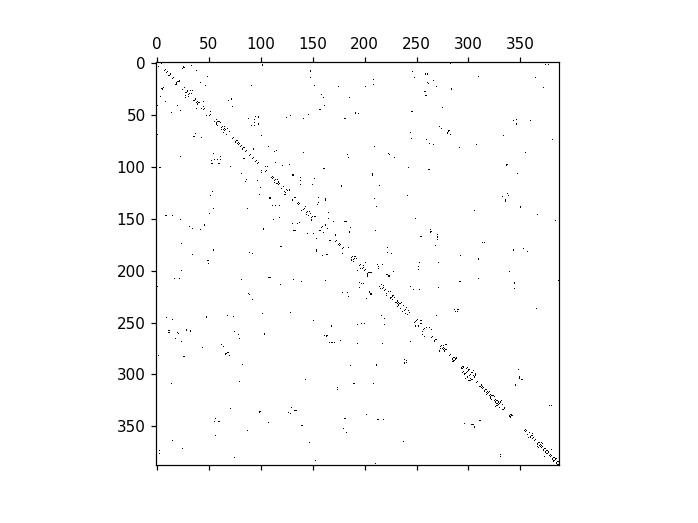

In [124]:
plt.figure()
plt.spy(A)

# Get Coordinates of nodes:

In [196]:
nodes = ctown.wn.nodes.todict()

In [197]:
coords_arr = np.array([nodes[key]['coordinates'] for key in nodes.keys()])
coords = pd.DataFrame(coords_arr, index=node_names_all)

# Clustering

In [293]:
with open('results.pkl', 'rb') as f:
    results=pickle.load(f)

In [294]:
press_junctions =results.node['pressure'][node_names[2]]
dqual_junctions = results.node['quality'][node_names[2]].diff(axis=0).dropna()
junction_coords = coords.loc[node_names[2]]

Normalize Data:

In [295]:
press_junctions /= press_junctions.max()
dqual_junctions /=  dqual_junctions.max()

## Pressure Clustering

In [322]:
X = press_junctions.to_numpy()

In [323]:
n_clusters = 30
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(X)
cluster_labels = pd.DataFrame(clustering.labels_, index=node_names[2])

<IPython.core.display.Javascript object>


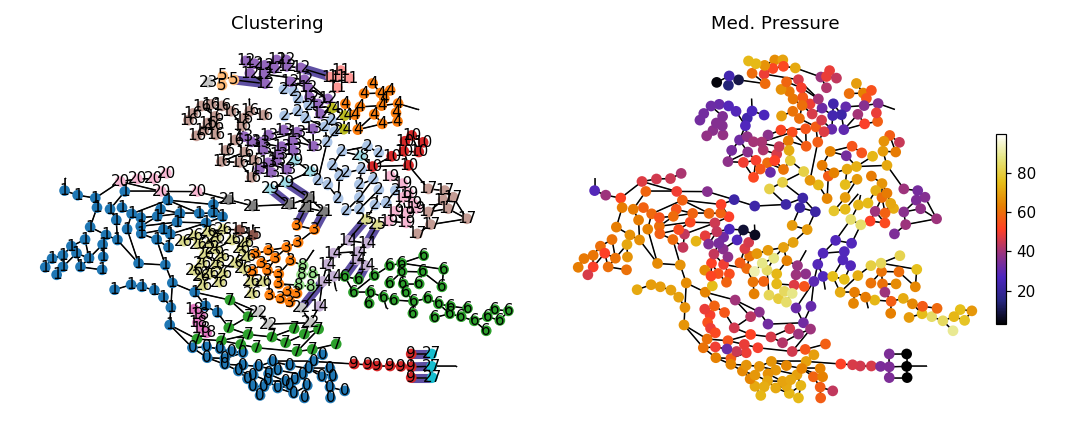

In [324]:
fig_1, ax_1 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
press = results.node['pressure']
press_med = press.median()

wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Pumps', ax=ax_1[0])
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Valves', ax=ax_1[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=cluster_labels[0],node_size=50, node_labels=False, node_cmap='tab20',add_colorbar=False, title='Clustering', ax=ax_1[0])  # clustering
wntr.graphics.plot_network(ctown.wn, node_attribute=press_med[node_names[2]],node_size=50, node_cmap='CMRmap', title='Med. Pressure', ax=ax_1[1])  # junctions


if False:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].mean()
        ax_1[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8), alpha=0.8))
if True:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_1[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_1.tight_layout()



### Evaluation

<IPython.core.display.Javascript object>


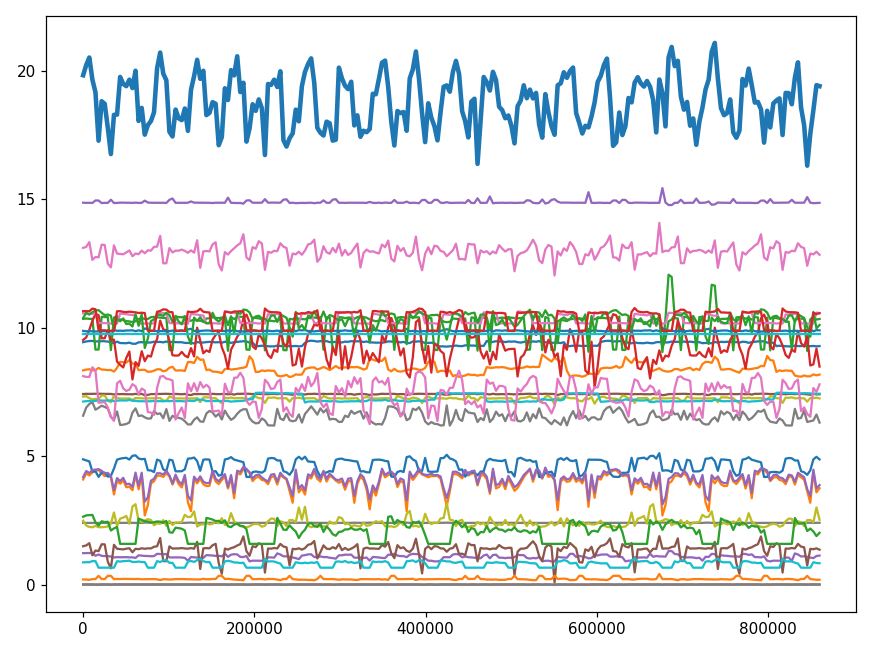

In [325]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

for i in range(n_clusters):
    cluster_i = np.array(node_names[2])[clustering.labels_==i]
    press_std_i = results.node['pressure'][cluster_i].std(axis=1)
    
    ax_2.plot(press_std_i, label=str(i))

press_std_ges = results.node['pressure'].std(axis=1)
ax_2.plot(press_std_ges, linewidth=3)

fig_2.tight_layout()   

## Quality Clustering

In [326]:
X = dqual_junctions.to_numpy()

In [327]:
n_clusters = 30
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(X)
cluster_labels = pd.DataFrame(clustering.labels_, index=node_names[2])

<IPython.core.display.Javascript object>


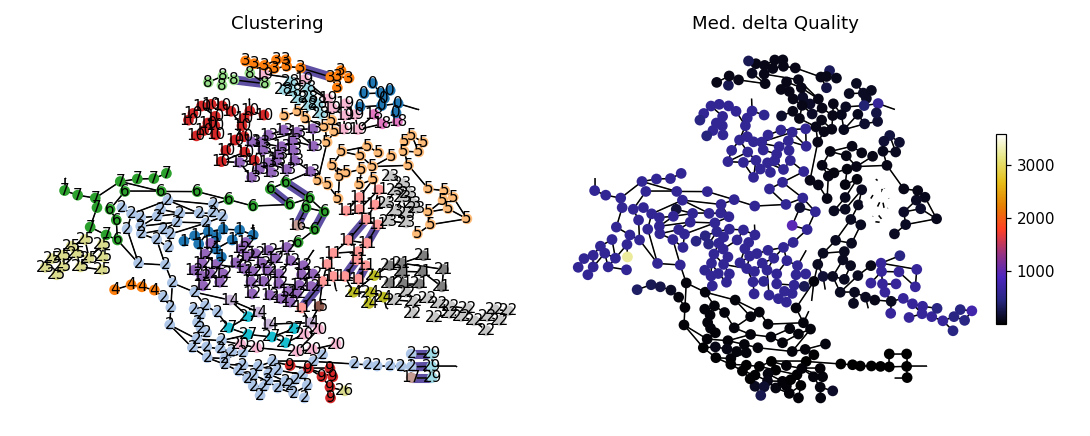

In [328]:
fig_2, ax_2 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
dqual = results.node['quality'].diff().dropna()
dqual_med = dqual.mean()

wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Pumps', ax=ax_2[0])
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Valves', ax=ax_2[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=cluster_labels[0],node_size=50, node_labels=False, node_cmap='tab20',add_colorbar=False, title='Clustering', ax=ax_2[0])  # clustering
wntr.graphics.plot_network(ctown.wn, node_attribute=dqual_med[node_names[2]],node_size=50, node_cmap='CMRmap', title='Med. delta Quality', ax=ax_2[1])  # junctions


if False:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].mean()
        ax_2[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8), alpha=0.8))
if True:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_2[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_2.tight_layout()



### Evaluation

<IPython.core.display.Javascript object>


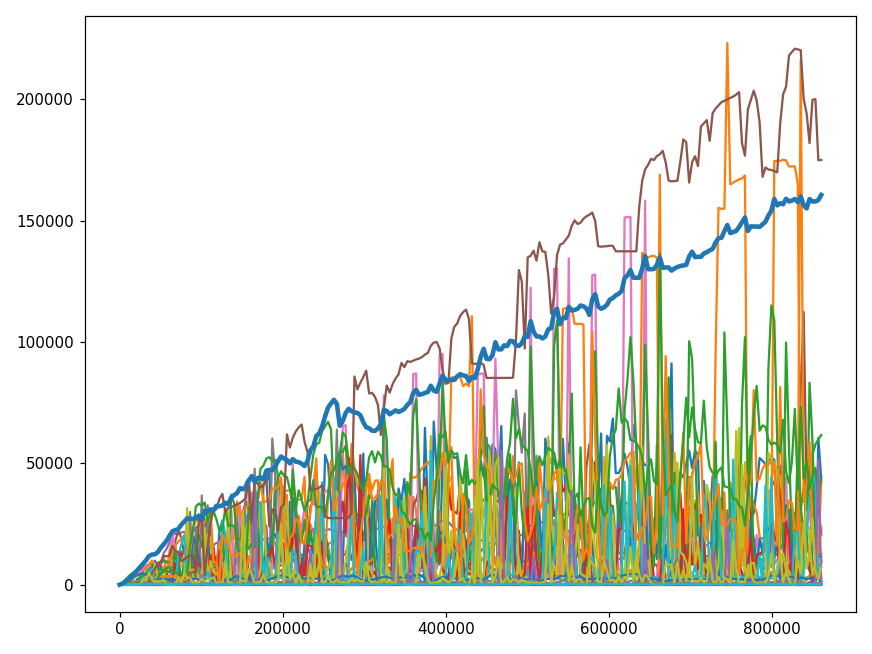

In [329]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

for i in range(n_clusters):
    cluster_i = np.array(node_names[2])[clustering.labels_==i]
    dqual_std_i = results.node['quality'][cluster_i].dropna().std(axis=1)
    
    ax_2.plot(dqual_std_i, label=str(i))
    
dqual_std_ges = results.node['quality'].dropna().std(axis=1)
ax_2.plot(dqual_std_ges, linewidth=3)

fig_2.tight_layout()  